# Neural Network
These are functions needed for the Neural Network

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def initialise_network(network_structure):
    for i in range(1, len(network_structure)):
        network_structure[i]["W"] = np.random.randn(network_structure[i]["size"], network_structure[i-1]["size"]) * 0.1
        network_structure[i]["b"] = np.zeros((network_structure[i]["size"], 1))
        
    return network_structure

In [3]:
def forward_propagation(network, X):
    assert(X.shape[0] == network[0]["size"])
    network[0]["A"] = X
    for i in range(1, len(network)):
        network[i]["Z"] = (network[i]["W"] @ network[i-1]["A"]) + network[i]["b"]
        network[i]["A"] = activation_function(network[i]["Z"], network[i]["activation"] )
        

In [4]:
def sigmoid(Z):
     return 1 / (1 + np.exp(-Z))

def sigmoid_derivative(Z):
    return sigmoid(Z) * (1 - sigmoid(Z))

In [5]:
def ReLU(Z):
     return np.maximum(0, Z)

def ReLU_derivative(Z):
    return np.where(Z > 0, 1, 0)

In [6]:
def Tanh(Z):
    return np.tanh(Z)

def Tanh_derivative(Z):
    return 1 - (Tanh(Z) * Tanh(Z))

In [7]:
def LeakyReLU(Z):
    return np.where(Z > 0, Z, 0.1 * Z)

def LeakyReLU_derivative(Z):
    return np.where(Z > 0, 1, 0.1)

In [8]:
def nan(M):
    if np.any(np.isnan(M)):
        return True
    else:
        return False

In [9]:
def nanExcept(M, text):
    if nan(M):
        raise Exception("Nan Exception Code: ", text)

In [10]:
def Softmax(Z):
    nanExcept(Z, "Z input Softmax")
    #getting max value for each column
    maxs = np.amax(Z, axis = 0, keepdims = True)
    Z_diminished = Z
    if nan(Z_diminished):
        print("Z_DIM")
        print(Z, maxs, Z_diminished)
    
    #Softmax
    exp = np.exp(Z_diminished)
    exp_sums = np.sum(exp, axis = 0, keepdims = True)
    result = exp / (exp_sums + 0.00000001)
    nanExcept(result, "Softmax")
    return result

In [11]:
def activation_function(Z, activation):
    if activation == "Sigmoid":
        return sigmoid(Z)
    elif activation == "ReLU":
        return ReLU(Z)
    elif activation == "Tanh":
        return Tanh(Z)
    elif activation == "LeakyReLU":
        return LeakyReLU(Z)
    elif activation == "Softmax":
        return Softmax(Z)
    else:
        raise Exception("Activation Function not defined")

In [12]:
def compute_cost(network, X, Y):
    forward_propagation(network, X)
    AL = network[-1]["A"]
    assert(AL.shape == Y.shape)
    if network[-1]["loss"] == "MSE":
        mse = (1 / Y.shape[1]) * np.sum(MSE_loss(AL, Y), axis = 1, keepdims = True)
        return mse.item(0)
    if network[-1]["loss"] == "CrossEntropy":
        crossE = (1 / Y.shape[1]) * np.sum(Cross_Entropy_loss(AL, Y), axis = 1, keepdims = True)
        return crossE.item(0)
    else:
        raise Exception("Loss Function not defined")
    

In [13]:
def MSE_loss(AL, Y):
    diff = AL - Y
    square_diff = diff * diff
    mse_loss = (1 / Y.shape[0]) * np.sum(square_diff, axis = 0, keepdims = True)
    return mse_loss

In [14]:
def Cross_Entropy_loss(AL, Y):
    result = -Y * np.log(AL)
    result = np.sum(result, axis = 0, keepdims = True)
    
    nanExcept(result, "Cross Entropy")
    return result

In [15]:
def backward_cost(network, Y):
    AL = network[-1]["A"]
    assert(AL.shape == Y.shape)
    n = AL.shape[0]
    if network[-1]["loss"] == "MSE":
        return (2 / n) * (AL - Y)
    else:
        raise Exception("Loss Function Derivative not defined")

In [16]:
def backward_activation(dA, layer):
    if layer["activation"] == "Sigmoid":
        return dA * (layer["A"] * (1 - layer["A"]))
    elif layer["activation"] == "ReLU":
        return dA * ReLU_derivative(layer["Z"])
    elif layer["activation"] == "Tanh":
        return dA * (1 - (layer["A"] * layer["A"]))
    elif layer["activation"] == "LeakyReLU":
        return dA * LeakyReLU_derivative(layer["Z"])
    elif layer["activation"] == "Softmax":
        return layer["A"] * (dA - np.sum(dA * layer["A"], axis = 0, keepdims = True))
    else:
        raise Exception("Activation Function Derivative not defined")

In [17]:
def backward_propagation(network, Y, learning_rate, epoch):
    L = len(network) - 1
    m = Y.shape[1]
    
    #special Case: Softmax Regression
    if(network[L]["activation"] == "Softmax" and network[L]["loss"] == "CrossEntropy"):
        dZ = network[L]["A"] - Y
    else:
        dA = backward_cost(network, Y)
        dZ = backward_activation(dA, network[L])
        
    
    for layer in reversed(range(1, L + 1)):
        network[layer]["dW"] = (1 / m) * dZ @ network[layer - 1]["A"].T
        network[layer]["db"] = (1 / m) * np.sum(dZ, axis = 1, keepdims = 1)
        
        #Deriving to next (previous) layer
        if layer != 1:
            dA = network[layer]["W"].T @ dZ
            dZ = backward_activation(dA, network[layer - 1])
            
        #Storing Momentun
        beta1 = 0.9
        network[layer]["vW"] = beta1 * network[layer]["vW"] + (1 - beta1) * network[layer]["dW"]
        network[layer]["vb"] = beta1 * network[layer]["vb"] + (1 - beta1) * network[layer]["db"]
        
        
        #Storing RMSProp
        beta2 = 0.99
        network[layer]["aW"] = beta2 * network[layer]["aW"] + (1 - beta2) * (network[layer]["dW"] ** 2)
        network[layer]["ab"] = beta2 * network[layer]["ab"] + (1 - beta2) * (network[layer]["db"] ** 2)
        
        
        #Applying Step
        network[layer]["W"] = network[layer]["W"] - learning_rate * (network[layer]["vW"] / (np.sqrt(network[layer]["aW"]) + 0.000000001))
        network[layer]["b"] = network[layer]["b"] - learning_rate * (network[layer]["vb"] / (np.sqrt(network[layer]["ab"]) + 0.000000001))
        
        

In [18]:
def model_fit(network, X_set, Y_set, batch_size, learning_rate, num_iterations, print_cost = True):
    assert(X_set.shape[1] == Y_set.shape[1])
    assert(batch_size <= X_set.shape[1])
    
    if not "W" in network[1]:
        print("Initialising Network...")
        initialise_network(network)
        
    if not "dW" in network[1]:
        for layer in range(1, len(network)):
            #Momentum
            network[layer]["vW"] = np.zeros(network[layer]["W"].shape)
            network[layer]["vb"] = np.zeros(network[layer]["b"].shape)
            
            #AdaGrad
            network[layer]["aW"] = np.zeros(network[layer]["W"].shape)
            network[layer]["ab"] = np.zeros(network[layer]["b"].shape)
    
    costs = []
    
    for epoch in range(0, num_iterations):
        
        #Creating Batch
        randomIndices = np.random.randint(X_set.shape[1], size = batch_size)
        X = X_set[:,randomIndices]
        Y = Y_set[:,randomIndices]
        
        #Whole Cycle
        forward_propagation(network, X)
        backward_propagation(network, Y, learning_rate, epoch)
        
        if epoch % 1000 == 0 and print_cost:
            cost = compute_cost(network, X_set, Y_set)
            costs.append(cost)
            print("Current Cost at: ", cost)
            
    return costs


# Classification Problem
### Problem Description

In this Notebook we like to demonstrate the ability of a neural Network to perform multi-class Classification.
In this example we will classify Points on the 2D plane into 3 different classes:

Class 0: blue<br>
Class 1: orange<br>
Class 2: green<br>

### Network

The network's input will be a 2D-vector representing the point X and Y coordinates
This vector will be transformed by multiple layers to a 3-neuron output layer.
The output layer uses CrossEntropy activation and gives probabilities of the input point belonging to one of the classes:

[0.2]<br>
[0.1]<br>
[0.7] ---> Biggest Probability : Class 2<br>

### Optimization

The implementation above uses Adam Optimization.
It first calculates the partial derivatives of the Loss with respect to all the weights of the Network,<br>
then smoothes them by calculating averages between different timesteps<br>and finally substracts these derivatives, scaled by the learning rate, from the actual weight.

## Generating Traing Data

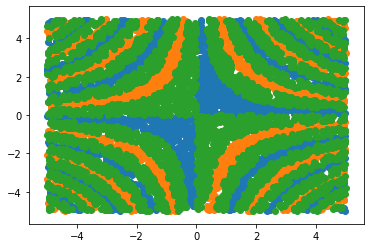

In [32]:
import keras.utils

m = 8000
X = np.random.rand(2, m) * 10 - 5
Y = np.zeros((1, m))
Y = np.where(np.sin(X[1,:] * X[0,:]) < 0, 1 , Y[0:]).reshape(1, m)
Y = np.where(np.tan(X[0,:] * X[1,:]) < 0, 2 , Y[0:]).reshape(1, m)
plt.scatter(np.where(Y[0,:] == 0, X[0,:], 0), np.where(Y[0,:] == 0, X[1,:], 0))
plt.scatter(np.where(Y[0,:] == 1, X[0,:], 0), np.where(Y[0,:] == 1, X[1,:], 0))
plt.scatter(np.where(Y[0,:] == 2, X[0,:], 0), np.where(Y[0,:] == 2, X[1,:], 0))

Y = keras.utils.to_categorical(Y, 3).squeeze().T

## Generating Model

In [65]:
network = [
    {"size": 2},
    {"size":15,"activation":"LeakyReLU"},
    {"size":15,"activation":"LeakyReLU"},
    {"size":15,"activation":"LeakyReLU"},
    {"size":15,"activation":"LeakyReLU"},
    {"size":15,"activation":"LeakyReLU"},
    {"size":15,"activation":"LeakyReLU"},
    {"size":3, "activation":"Softmax", "loss":"CrossEntropy"}
]

Initialising Network...
Current Cost at:  1.092748225103243
Current Cost at:  0.47844131024185643
Current Cost at:  0.3907604713907531
Current Cost at:  0.32537528268030746
Current Cost at:  0.33276790717838567
Current Cost at:  0.2702811983520074
Current Cost at:  0.2576682085048305
Current Cost at:  0.2494809041767199
Current Cost at:  0.22859853702935637
Current Cost at:  0.2611250693997092
Current Cost at:  0.22452009586730032
Current Cost at:  0.24398618823245422
Current Cost at:  0.21871496462715187
Current Cost at:  0.16874109017999242
Current Cost at:  0.2137477220837321
Current Cost at:  0.19656330138113298
Current Cost at:  0.17781413979808827
Current Cost at:  0.15906358505820622
Current Cost at:  0.15214790043927304
Current Cost at:  0.16966602174826995


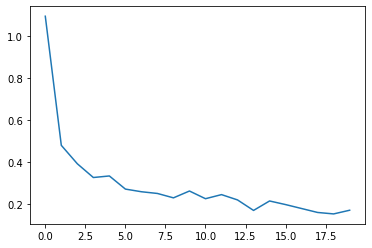

In [66]:
costs = model_fit(network, X, Y, 600, 0.01, 20000)
plt.plot(costs)

## Results

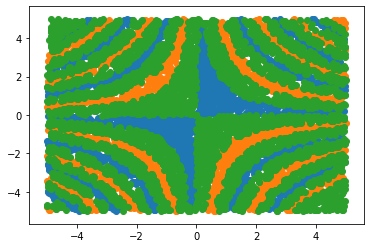

In [67]:
#Plotting Results
m = 8000
zoom = 10
X_test = np.random.rand(2, m) * zoom - zoom / 2
forward_propagation(network, X_test)
Y_test = network[-1]["A"]
Y_test = np.argmax(Y_test, axis = 0).reshape(1,m)
fig = plt.figure()
ax = plt.axes()
ax.scatter(np.where(Y_test[0,:] == 0, X_test[0,:], 0), np.where(Y_test[0,:] == 0, X_test[1,:], 0))
ax.scatter(np.where(Y_test[0,:] == 1, X_test[0,:], 0), np.where(Y_test[0,:] == 1, X_test[1,:], 0))
ax.scatter(np.where(Y_test[0,:] == 2, X_test[0,:], 0), np.where(Y_test[0,:] == 2, X_test[1,:], 0))

plt.show()

## Generate Movie Frames

In [ ]:
for i in range(300):
    model_fit(network, X, Y, 600, 0.001, 3)
    #Plotting Results
    m = 8000
    zoom = 10
    X_test = np.random.rand(2, m) * zoom - zoom / 2
    forward_propagation(network, X_test)
    Y_test = network[-1]["A"]
    Y_test = np.argmax(Y_test, axis = 0).reshape(1,m)
    fig = plt.figure()
    ax = plt.axes()
    ax.scatter(np.where(Y_test[0,:] == 0, X_test[0,:], 0), np.where(Y_test[0,:] == 0, X_test[1,:], 0))
    ax.scatter(np.where(Y_test[0,:] == 1, X_test[0,:], 0), np.where(Y_test[0,:] == 1, X_test[1,:], 0))
    ax.scatter(np.where(Y_test[0,:] == 2, X_test[0,:], 0), np.where(Y_test[0,:] == 2, X_test[1,:], 0))

    fig.savefig("img/img"+str(i)+".png")